## 肺癌のセグメンテーションと良悪性の判別モデル

１．CTデータをpytorchで扱えるように

２．肺の腫瘍のみをセグメンテーション（タスクの焦点を絞るために）

３．関心ボクセルをグループ化して結節候補をまとめる

４．結節候補をConvalutonで分類する

５．結節ごとを患者ごとへの評価にする（今回は悪性度の最大値）

こぶの内悪性が結節
annotationsは結節フラグの大きさ
candidatesはすべてのこぶ情報

## annotaitonとcandidateで位置の統合

In [221]:
import copy
import random

from collections import namedtuple
CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    'isNodule_bool, diameter_mm, series_uid, center_xyz',
)

In [222]:
CandidateInfoTuple

__main__.CandidateInfoTuple

In [223]:
#CTデータの内mhdファイルをリストにする
#メモリに残す関数:lru_cache

import functools
import glob
import os

#mhd_list = glob.glob('data-unversioned/part2/luna/subset*/*.mhd')
mhd_list = glob.glob('../deep-learning-with-pytorch-ja/data/part2/luna/subset*/*.mhd')

presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}

In [224]:
presentOnDisk_set

{'1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059'}

In [225]:
import csv


diameter_dict = {}
with open('../deep-learning-with-pytorch-ja/data/part2/luna/annotations.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])

            diameter_dict.setdefault(series_uid, []).append(
                (annotationCenter_xyz, annotationDiameter_mm)
            )

In [226]:
#diameter_dict

#uid一つに複数のこぶがある場合もあり、こぶの中心座標と大きさがvalueに入る。

In [227]:
a="1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405"

In [228]:
#辞書のaの要素を返す。なければ台に引数を返す。デフォはNone
b=diameter_dict.get(a,[])
print(b)
s=diameter_dict.get("lll",[])
print(s)
f=diameter_dict.get("lll")
print(f)


[((-24.0138242, 192.1024053, -391.0812764), 8.143261683), ((2.441546798, 172.4648812, -405.4937318), 18.54514997), ((90.93171321, 149.0272657, -426.5447146), 18.20857028), ((89.54076865, 196.4051593, -515.0733216), 16.38127631)]
[]
None


In [318]:
#sereis_uidでまわして、個々の結節の直径のデータごとに回して、ｘ、ｙ、ｚの各軸ごとにまわす

candidateInfo_list = []
with open('../deep-learning-with-pytorch-ja/data/part2/luna/candidates.csv', "r") as f:
    for row in list(csv.reader(f))[1:]:
        series_uid = row[0]
#presentOnDisk_setはCTデータのuid
#そこに無いのはスキップすることで直径０として使う
        if series_uid not in presentOnDisk_set :
            continue

        isNodule_bool = bool(int(row[4]))
        candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

        candidateDiameter_mm = 0.0
        for annotation_tup in diameter_dict.get(series_uid, []):
            annotationCenter_xyz, annotationDiameter_mm = annotation_tup
            for i in range(3):
                #距離（差）が大きいものは確認(直径/2/2との比較)
                delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])
                if delta_mm > annotationDiameter_mm / 4:
                    break
            else:
                # 差が小さいものは統一する
                candidateDiameter_mm = annotationDiameter_mm
                break

        candidateInfo_list.append(CandidateInfoTuple(
            isNodule_bool,
            candidateDiameter_mm,
            series_uid,
            candidateCenter_xyz,
        ))

In [319]:
candidateInfo_list[0:5]

[CandidateInfoTuple(isNodule_bool=False, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260', center_xyz=(129.56815129, 45.3770967403, -277.835757804)),
 CandidateInfoTuple(isNodule_bool=False, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260', center_xyz=(-97.26, 56.36, -201.93)),
 CandidateInfoTuple(isNodule_bool=False, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260', center_xyz=(99.2304910833, -4.88216543725, -128.691304564)),
 CandidateInfoTuple(isNodule_bool=False, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260', center_xyz=(-15.287525202, -59.1051002263, -251.303750179)),
 CandidateInfoTuple(isNodule_bool=False, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260', center_xyz=(109.344666074, 1.89173714531, -237.284698998))]

In [320]:
candidateInfo_list.sort(reverse=True)

In [321]:
candidateInfo_list[1:5]

[CandidateInfoTuple(isNodule_bool=True, diameter_mm=6.440878725, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492', center_xyz=(-100.46, 68.01, -230.55)),
 CandidateInfoTuple(isNodule_bool=True, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(44.25, 52.17, -110.25)),
 CandidateInfoTuple(isNodule_bool=True, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(36.54, 78.1, -122.92)),
 CandidateInfoTuple(isNodule_bool=False, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(49.0692129504, 23.0584814498, -98.6156878657))]

## CTデータ取込み

In [233]:
import SimpleITK as sitk
import numpy as np

In [234]:
from util.util import XyzTuple, xyz2irc


#series_uidごとにパスをつくり
mhd_path = glob.glob(
    '../deep-learning-with-pytorch-ja/data/part2/luna/subset*/*.mhd'.format(series_uid))[0]
#CTを取り込む
ct_mhd = sitk.ReadImage(mhd_path)
ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

#CT値をこの範囲のみに絞るそれ以外は今回の予測には不要と判断
#新たなデータが追加された時もこの処理をしたことを覚えておく必要がある。
ct_a.clip(-1000, 1000, ct_a)

#self.series_uid = series_uid
#self.hu_a = ct_a

array([[[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.]],

       [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.]],

       [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-10

In [235]:
ct_a.shape

(121, 512, 512)

ディープラーニングは固定長であるため、入力も固定長でないといけない。

## 位置座標の修正

データではmm,欲しいデータはボクセルの位置情報であるため、修正が必要

TrasformIndexToPhysicalPoint
TranformPhysicalPointToIndex
では画像データの読み込んで保持した後に変換する

保持しないで変換すすため自作している。IRCからXYZ

1、XYZに合わせるために座標をIRCからCRIに反転する

2、ボクセルサイズに合わせてインデックスをスケーリングする

3、pythonの＠で行列の積を行う

4、原点に対してオフセットを加える

In [236]:
# collectionの確認

from collections import namedtuple
N=namedtuple('Fruit',['apple','grape'])
N(*[1,2])  #　リストを展開

Fruit(apple=1, grape=2)

In [237]:
n=N(*[1,2])
n.apple

1

In [238]:
import numpy as np
a=np.zeros([3,3,4])
a[0:2]=1
a[1]=2
a

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [239]:
b=a[::-1]
b

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]])

In [240]:
import collections
IrcTuple = collections.namedtuple('IrcTuple', ['index', 'row', 'col'])
XyzTuple = collections.namedtuple('XyzTuple', ['x', 'y', 'z'])

In [241]:
#XyzTupleに三つ入れたらそれぞれx、y、zでそれぞれの要素を取り出せる
a=XyzTuple(*["x座標",'y座標','z座標'])
print(type(a))
a.x

<class '__main__.XyzTuple'>


'x座標'

In [242]:
for d, f in enumerate(a):
    print(d)
    print(f)

0
x座標
1
y座標
2
z座標


In [243]:
#CTデータから位置情報を取り出す
origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)

#原点 = (-127、-96、-110)
#ボクセルサイズ
#方向 = 恒等行列

In [244]:
origin_xyz

XyzTuple(x=-198.100006, y=-195.0, z=-335.209991)

In [245]:
vxSize_xyz

XyzTuple(x=0.7617189884185791, y=0.7617189884185791, z=2.5)

In [246]:
ct_mhd

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f16b231bd80> >

In [247]:
ct_mhd.GetDirection()

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

In [248]:
direction_a

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [249]:
# 結節の中心のデータ（mm)、原点、ボクセルサイズ、方向が引数
def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coord_a = np.array(coord_xyz)
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)
    return IrcTuple(int(cri_a[2]), int(cri_a[1]), int(cri_a[0]))

#戻り値はircの結節範囲

In [250]:
candidateInfo_tup = candidateInfo_list[0]
width_irc = (32, 48, 48)

In [251]:
candidateInfo_tup

CandidateInfoTuple(isNodule_bool=True, diameter_mm=13.59647134, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(46.00314143, 47.66525294, -108.4822128))

In [252]:
candidateInfo_tup.series_uid

'1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059'

In [253]:
class Ct:
    def __init__(self, series_uid):
        mhd_path = glob.glob(
            '../deep-learning-with-pytorch-ja/data/part2/luna/subset*/*.mhd'.format(series_uid)
        )[0]

        ct_mhd = sitk.ReadImage(mhd_path)
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

        # CTs are natively expressed in https://en.wikipedia.org/wiki/Hounsfield_scale
        # HU are scaled oddly, with 0 g/cc (air, approximately) being -1000 and 1 g/cc (water) being 0.
        # The lower bound gets rid of negative density stuff used to indicate out-of-FOV
        # The upper bound nukes any weird hotspots and clamps bone down
        ct_a.clip(-1000, 1000, ct_a)

        self.series_uid = series_uid
        self.hu_a = ct_a

        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)

    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(
            center_xyz,
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction_a,
        )

        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])

            assert center_val >= 0 and center_val < self.hu_a.shape[axis], repr([self.series_uid, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis])

            if start_ndx < 0:
                # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
                #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
                start_ndx = 0
                end_ndx = int(width_irc[axis])

            if end_ndx > self.hu_a.shape[axis]:
                # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
                #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])

            slice_list.append(slice(start_ndx, end_ndx))

        ct_chunk = self.hu_a[tuple(slice_list)]

        return ct_chunk, center_irc


In [254]:
def getCt(series_uid):
    return Ct(series_uid)

In [255]:
#CTの画像から指定の範囲をリストで取り出す
def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(
            center_xyz,
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction_a,
        )

        slice_list = []
        # 番号と座標が一軸ごとに取り出される
        # 中心に幅/2 から　幅分各軸取り出され
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])
            slice_list.append(slice(start_ndx, end_ndx))
            
        # ctデータからその範囲を選択して出力

        ct_chunk = ct_a[tuple(slice_list)]

        return ct_chunk, center_irc

In [256]:
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc


In [257]:
candidate_a, center_irc = getCtRawCandidate(
            candidateInfo_tup.series_uid,
            candidateInfo_tup.center_xyz,
            width_irc,
        )

In [258]:
candidateInfo_tup.series_uid

'1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059'

In [259]:
candidateInfo_tup.center_xyz

(46.00314143, 47.66525294, -108.4822128)

In [260]:
center_xyz = candidateInfo_tup.center_xyz

In [261]:
#IRCの結節の範囲
center_irc = xyz2irc(center_xyz,origin_xyz,vxSize_xyz,direction_a)

In [262]:
center_irc

IrcTuple(index=91, row=319, col=320)

In [263]:
candidate_a.shape

(32, 48, 48)

## pytorchへ変換

データセットクラスを作成する

標準化と画像のフラット化する

In [264]:
candidateInfo_list[0:5]

[CandidateInfoTuple(isNodule_bool=True, diameter_mm=13.59647134, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(46.00314143, 47.66525294, -108.4822128)),
 CandidateInfoTuple(isNodule_bool=True, diameter_mm=6.440878725, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492', center_xyz=(-100.46, 68.01, -230.55)),
 CandidateInfoTuple(isNodule_bool=True, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(44.25, 52.17, -110.25)),
 CandidateInfoTuple(isNodule_bool=True, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(36.54, 78.1, -122.92)),
 CandidateInfoTuple(isNodule_bool=False, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(49.0692129504, 23.0584814498, -98.6156878657))]

データセット作成

In [265]:
from torch.utils.data import Dataset

import torch
import torch.nn as nn
from torchvision import transforms


class LunaDataset(Dataset):
    def __init__(self):
        self.candidateInfo_list = candidateInfo_list
    
    
    
    # ndx:整数を引数にとり(0からN-1),1、結節か否か、2、UID、3、結節の場所（I ,R,C)、4、サンプルテンソルの四つのタプルを返す
    def __getitem__(self, ndx):
        
        
        #注意：中身がない
        
        return (
            candidate_t,
            pos_t,
            candidateInfo_tup.series_uid,
            torch.tensor(center_irc),
        )
        

In [266]:
candidateInfo_tup = candidateInfo_list[0]
width_irc = (32, 48, 48)

candidate_a, center_irc = getCtRawCandidate(
    candidateInfo_tup.series_uid,
    candidateInfo_tup.center_xyz,
    width_irc,
)

candidate_t = torch.from_numpy(candidate_a)

In [267]:
candidate_t.unsqueeze(0).shape

torch.Size([1, 32, 48, 48])

In [268]:
candidateInfo_tup.isNodule_bool

True

In [269]:
not candidateInfo_tup.isNodule_bool

False

In [270]:
pos_t = torch.tensor([
                not candidateInfo_tup.isNodule_bool,
                candidateInfo_tup.isNodule_bool
            ],
            dtype=torch.long,
        )

In [271]:
pos_t

tensor([0, 1])

## キャッシュ

すべてのサンプルについてディスクからCTスキャン全体を読み込まなくても済むようにする。
データ読み込みがボトルネックになるとキャッシングが必要だと考える。

Memoize とは

Memoize とは、キャッシュを用いて関数呼び出しを高速化する手法のことです。関数呼び出し時の引数をキーとして戻り値をキャッシュし、同じ引数で呼び出された場合にキャッシュの値を返す (関数呼び出しを省略する) ことで高速化します。

キャッシュされた値はdata-unservrsioned/cacheに保存されており、関数を変更した場合はそこのデータを削除しておかないと同じ出力をかえされることになる。

In [272]:
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc

In [273]:
class LunaDataset(Dataset):
    def __init__(self,
                 val_stride=0,
                 isValSet_bool=None,
                 series_uid=None,
            ):
        self.candidateInfo_list = copy.copy(getCandidateInfoList())

        if series_uid:
            self.candidateInfo_list = [
                x for x in self.candidateInfo_list if x.series_uid == series_uid
            ]

        if isValSet_bool:
            assert val_stride > 0, val_stride
            self.candidateInfo_list = self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
        elif val_stride > 0:
            del self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
        random.shuffle(self.candidateInfo_list)

        log.info("{!r}: {} {} samples".format(
            self,
            len(self.candidateInfo_list),
            "validation" if isValSet_bool else "training",
        ))

    def __len__(self):
        return len(self.candidateInfo_list)

    def __getitem__(self, ndx):
        candidateInfo_tup = self.candidateInfo_list[ndx]
        width_irc = (32, 48, 48)

        candidate_a, center_irc = getCtRawCandidate(
            candidateInfo_tup.series_uid,
            candidateInfo_tup.center_xyz,
            width_irc,
        )

        candidate_t = torch.from_numpy(candidate_a)
        candidate_t = candidate_t.to(torch.float32)
        candidate_t = candidate_t.unsqueeze(0)

        pos_t = torch.tensor([
                not candidateInfo_tup.isNodule_bool,
                candidateInfo_tup.isNodule_bool
            ],
            dtype=torch.long,
        )

        return (
            candidate_t,
            pos_t,
            candidateInfo_tup.series_uid,
            torch.tensor(center_irc),
        )


## 訓練と検証データの分割

val_stride に　N　の値を入れ、1/Nのデータを抜いて検証データとして分ける

In [275]:
a=[1,2,3,4,5,6,7,8,9]
a[:2]

[1, 2]

In [276]:
a[::2]

[1, 3, 5, 7, 9]

In [277]:
len(candidateInfo_list[::10])

230

In [278]:
len(candidateInfo_list[::5])

460

In [279]:
len(candidateInfo_list[::])

2298

In [280]:
for x in candidateInfo_list[:10]:
    print(x, x[0], x[1])

CandidateInfoTuple(isNodule_bool=True, diameter_mm=13.59647134, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(46.00314143, 47.66525294, -108.4822128)) True 13.59647134
CandidateInfoTuple(isNodule_bool=True, diameter_mm=6.440878725, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492', center_xyz=(-100.46, 68.01, -230.55)) True 6.440878725
CandidateInfoTuple(isNodule_bool=True, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(44.25, 52.17, -110.25)) True 0.0
CandidateInfoTuple(isNodule_bool=True, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(36.54, 78.1, -122.92)) True 0.0
CandidateInfoTuple(isNodule_bool=False, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(49.0692129504, 23.0584814498, -98.6156878657)) False 0.0
CandidateInfoTuple(isNodu

In [281]:
diameter_list = [x[1] for x in positiveInfo_list]

In [282]:
for i in range(0, len(diameter_list)):
    print("{:}   {:4.1f} mm".format(i, diameter_list[i]))

0   13.6 mm
1    6.4 mm
2    0.0 mm
3    0.0 mm


In [283]:
#この場合は１/N分のデータ
dataset_val = LunaDataset(val_stride=2,isValSet_bool=True,)

2022-08-07 11:26:17,354 INFO     pid:24 __main__:023:__init__ <__main__.LunaDataset object at 0x7f16b22818e0>: 1149 validation samples


In [284]:
len(dataset_val)

1149

In [285]:
# この場合は1/N分の削除したデータ
dataset_train = LunaDataset(val_stride=2)

2022-08-07 11:26:17,723 INFO     pid:24 __main__:023:__init__ <__main__.LunaDataset object at 0x7f16b23ef430>: 1149 training samples


In [286]:
len(dataset_train)

1149

In [287]:
dataset = LunaDataset()
len(dataset)

2022-08-07 11:26:17,763 INFO     pid:24 __main__:023:__init__ <__main__.LunaDataset object at 0x7f16b1954f40>: 2298 training samples


2298

## 描画

In [336]:
import random
import copy
import csv
import functools
import glob
import os

from collections import namedtuple

import SimpleITK as sitk
import numpy as np

import torch
import torch.cuda
from torch.utils.data import Dataset

from util.disk import getCache
from util.util import XyzTuple, xyz2irc
from util.logconf import logging

log = logging.getLogger(__name__)
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

raw_cache = getCache('part2ch10_raw')

CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    'isNodule_bool, diameter_mm, series_uid, center_xyz',
)

@functools.lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=True):
    # We construct a set with all series_uids that are present on disk.
    # This will let us use the data, even if we haven't downloaded all of
    # the subsets yet.
    mhd_list = glob.glob('../deep-learning-with-pytorch-ja/data/part2/luna/subset*/*.mhd')
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}

    diameter_dict = {}
    with open('../deep-learning-with-pytorch-ja/data/part2/luna/annotations.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])

            diameter_dict.setdefault(series_uid, []).append(
                (annotationCenter_xyz, annotationDiameter_mm)
            )

    candidateInfo_list = []
    with open('../deep-learning-with-pytorch-ja/data/part2/luna/candidates.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]

            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue

            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

            candidateDiameter_mm = 0.0
            for annotation_tup in diameter_dict.get(series_uid, []):
                annotationCenter_xyz, annotationDiameter_mm = annotation_tup
                for i in range(3):
                    delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])
                    if delta_mm > annotationDiameter_mm / 4:
                        break
                else:
                    candidateDiameter_mm = annotationDiameter_mm
                    break

            candidateInfo_list.append(CandidateInfoTuple(
                isNodule_bool,
                candidateDiameter_mm,
                series_uid,
                candidateCenter_xyz,
            ))

    candidateInfo_list.sort(reverse=True)
    return candidateInfo_list

class Ct:
    def __init__(self, series_uid):
        mhd_path = glob.glob(
            '../deep-learning-with-pytorch-ja/data/part2/luna/subset*/*.mhd'.format(series_uid)
        )[0]

        ct_mhd = sitk.ReadImage(mhd_path)
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

        # CTs are natively expressed in https://en.wikipedia.org/wiki/Hounsfield_scale
        # HU are scaled oddly, with 0 g/cc (air, approximately) being -1000 and 1 g/cc (water) being 0.
        # The lower bound gets rid of negative density stuff used to indicate out-of-FOV
        # The upper bound nukes any weird hotspots and clamps bone down
        ct_a.clip(-1000, 1000, ct_a)

        self.series_uid = series_uid
        self.hu_a = ct_a

        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)

    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(
            center_xyz,
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction_a,
        )

        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])

            assert center_val >= 0 and center_val < self.hu_a.shape[axis], repr([self.series_uid, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis])

            if start_ndx < 0:
                # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
                #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
                start_ndx = 0
                end_ndx = int(width_irc[axis])

            if end_ndx > self.hu_a.shape[axis]:
                # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
                #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])

            slice_list.append(slice(start_ndx, end_ndx))

        ct_chunk = self.hu_a[tuple(slice_list)]

        return ct_chunk, center_irc


def getCt(series_uid):
    return Ct(series_uid)

@raw_cache.memoize(typed=True)
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc

class LunaDataset(Dataset):
    def __init__(self,
                 val_stride=0,
                 isValSet_bool=None,
                 series_uid=None,
            ):
        self.candidateInfo_list = copy.copy(getCandidateInfoList())

        if series_uid:
            self.candidateInfo_list = [
                x for x in self.candidateInfo_list if x.series_uid == series_uid
            ]

        if isValSet_bool:
            assert val_stride > 0, val_stride
            self.candidateInfo_list = self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
        elif val_stride > 0:
            del self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
        random.shuffle(self.candidateInfo_list)

        log.info("{!r}: {} {} samples".format(
            self,
            len(self.candidateInfo_list),
            "validation" if isValSet_bool else "training",
        ))

    def __len__(self):
        return len(self.candidateInfo_list)

    def __getitem__(self, ndx):
        candidateInfo_tup = self.candidateInfo_list[ndx]
        width_irc = (32, 48, 48)

        candidate_a, center_irc = getCtRawCandidate(
            candidateInfo_tup.series_uid,
            candidateInfo_tup.center_xyz,
            width_irc,
        )

        candidate_t = torch.from_numpy(candidate_a)
        candidate_t = candidate_t.to(torch.float32)
        candidate_t = candidate_t.unsqueeze(0)

        pos_t = torch.tensor([
                not candidateInfo_tup.isNodule_bool,
                candidateInfo_tup.isNodule_bool
            ],
            dtype=torch.long,
        )

        return (
            candidate_t,
            pos_t,
            candidateInfo_tup.series_uid,
            torch.tensor(center_irc),
        )


In [337]:
ds = LunaDataset()

print(len(ds))
print(len(ds.candidateInfo_list))
for sample_tup in ds.candidateInfo_list:
        if sample_tup.isNodule_bool:
            print( sample_tup)

2022-08-07 11:51:09,514 INFO     pid:24 __main__:171:__init__ <__main__.LunaDataset object at 0x7f16b24a0c10>: 2298 training samples


2298
2298
CandidateInfoTuple(isNodule_bool=True, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(36.54, 78.1, -122.92))
CandidateInfoTuple(isNodule_bool=True, diameter_mm=13.59647134, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(46.00314143, 47.66525294, -108.4822128))
CandidateInfoTuple(isNodule_bool=True, diameter_mm=6.440878725, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492', center_xyz=(-100.46, 68.01, -230.55))
CandidateInfoTuple(isNodule_bool=True, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(44.25, 52.17, -110.25))


In [338]:
ds.candidateInfo_list[1:5]

[CandidateInfoTuple(isNodule_bool=False, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260', center_xyz=(-59.45, -28.35, -115.91)),
 CandidateInfoTuple(isNodule_bool=False, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492', center_xyz=(-1.27003848303, -69.9545137947, -125.637901437)),
 CandidateInfoTuple(isNodule_bool=False, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260', center_xyz=(-74.7493708266, -54.5561884079, -275.122764873)),
 CandidateInfoTuple(isNodule_bool=False, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260', center_xyz=(106.48, 19.26, -244.94))]

In [399]:
import matplotlib.pyplot as plt
clim=(-1000.0, 300)



def findPositiveSamples(start_ndx=0, limit=100):
    ds = LunaDataset()

    positiveSample_list = []
    for sample_tup in ds.candidateInfo_list:
        if sample_tup.isNodule_bool:
            print(len(positiveSample_list), sample_tup)
            positiveSample_list.append(sample_tup)

        if len(positiveSample_list) >= limit:
            break

    return positiveSample_list

def showCandidate(series_uid, batch_ndx=None, **kwargs):
    ds = LunaDataset(series_uid=series_uid, **kwargs)
    pos_list = [i for i, x in enumerate(ds.candidateInfo_list) if x.isNodule_bool]
#    
    print(pos_list[0])
    print(pos_list)
#    

    if batch_ndx is None:
        if pos_list:
            batch_ndx = pos_list[0]
        else:
            print("Warning: no positive samples found; using first negative sample.")
            batch_ndx = 0
# 
    print(batch_ndx)
#
    ct = Ct(series_uid)
    ct_t, pos_t, series_uid, center_irc = ds[batch_ndx]
    ct_a = ct_t[0].numpy()

    fig = plt.figure(figsize=(30, 50))

    group_list = [
        [9, 11, 13],
        [15, 16, 17],
        [19, 21, 23],
    ]

    subplot = fig.add_subplot(len(group_list) + 2, 3, 1)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[int(center_irc[0])], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 2)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,int(center_irc[1])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 3)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,:,int(center_irc[2])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 4)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[ct_a.shape[0]//2], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 5)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,ct_a.shape[1]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 6)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,:,ct_a.shape[2]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    for row, index_list in enumerate(group_list):
        for col, index in enumerate(index_list):
            subplot = fig.add_subplot(len(group_list) + 2, 3, row * 3 + col + 7)
            subplot.set_title('slice {}'.format(index), fontsize=30)
            for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
                label.set_fontsize(20)
            plt.imshow(ct_a[index], clim=clim, cmap='gray')


    print(series_uid, batch_ndx, bool(pos_t[0]), pos_list)


In [394]:
#Trueだけのりすと
positiveSample_list = findPositiveSamples()

2022-08-07 12:05:42,012 INFO     pid:24 __main__:171:__init__ <__main__.LunaDataset object at 0x7f16b18aa190>: 2298 training samples


0 CandidateInfoTuple(isNodule_bool=True, diameter_mm=6.440878725, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492', center_xyz=(-100.46, 68.01, -230.55))
1 CandidateInfoTuple(isNodule_bool=True, diameter_mm=13.59647134, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(46.00314143, 47.66525294, -108.4822128))
2 CandidateInfoTuple(isNodule_bool=True, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(44.25, 52.17, -110.25))
3 CandidateInfoTuple(isNodule_bool=True, diameter_mm=0.0, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059', center_xyz=(36.54, 78.1, -122.92))


In [395]:
len(positiveSample_list)

4

In [396]:
positiveSample_list[0][2]

'1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492'

In [397]:
series_uid = positiveSample_list[3][2]
series_uid 

'1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059'

2022-08-07 12:06:24,754 INFO     pid:24 __main__:171:__init__ <__main__.LunaDataset object at 0x7f16b19a4b50>: 508 training samples


263
[263, 293, 402]
263
1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059 263 False [263, 293, 402]


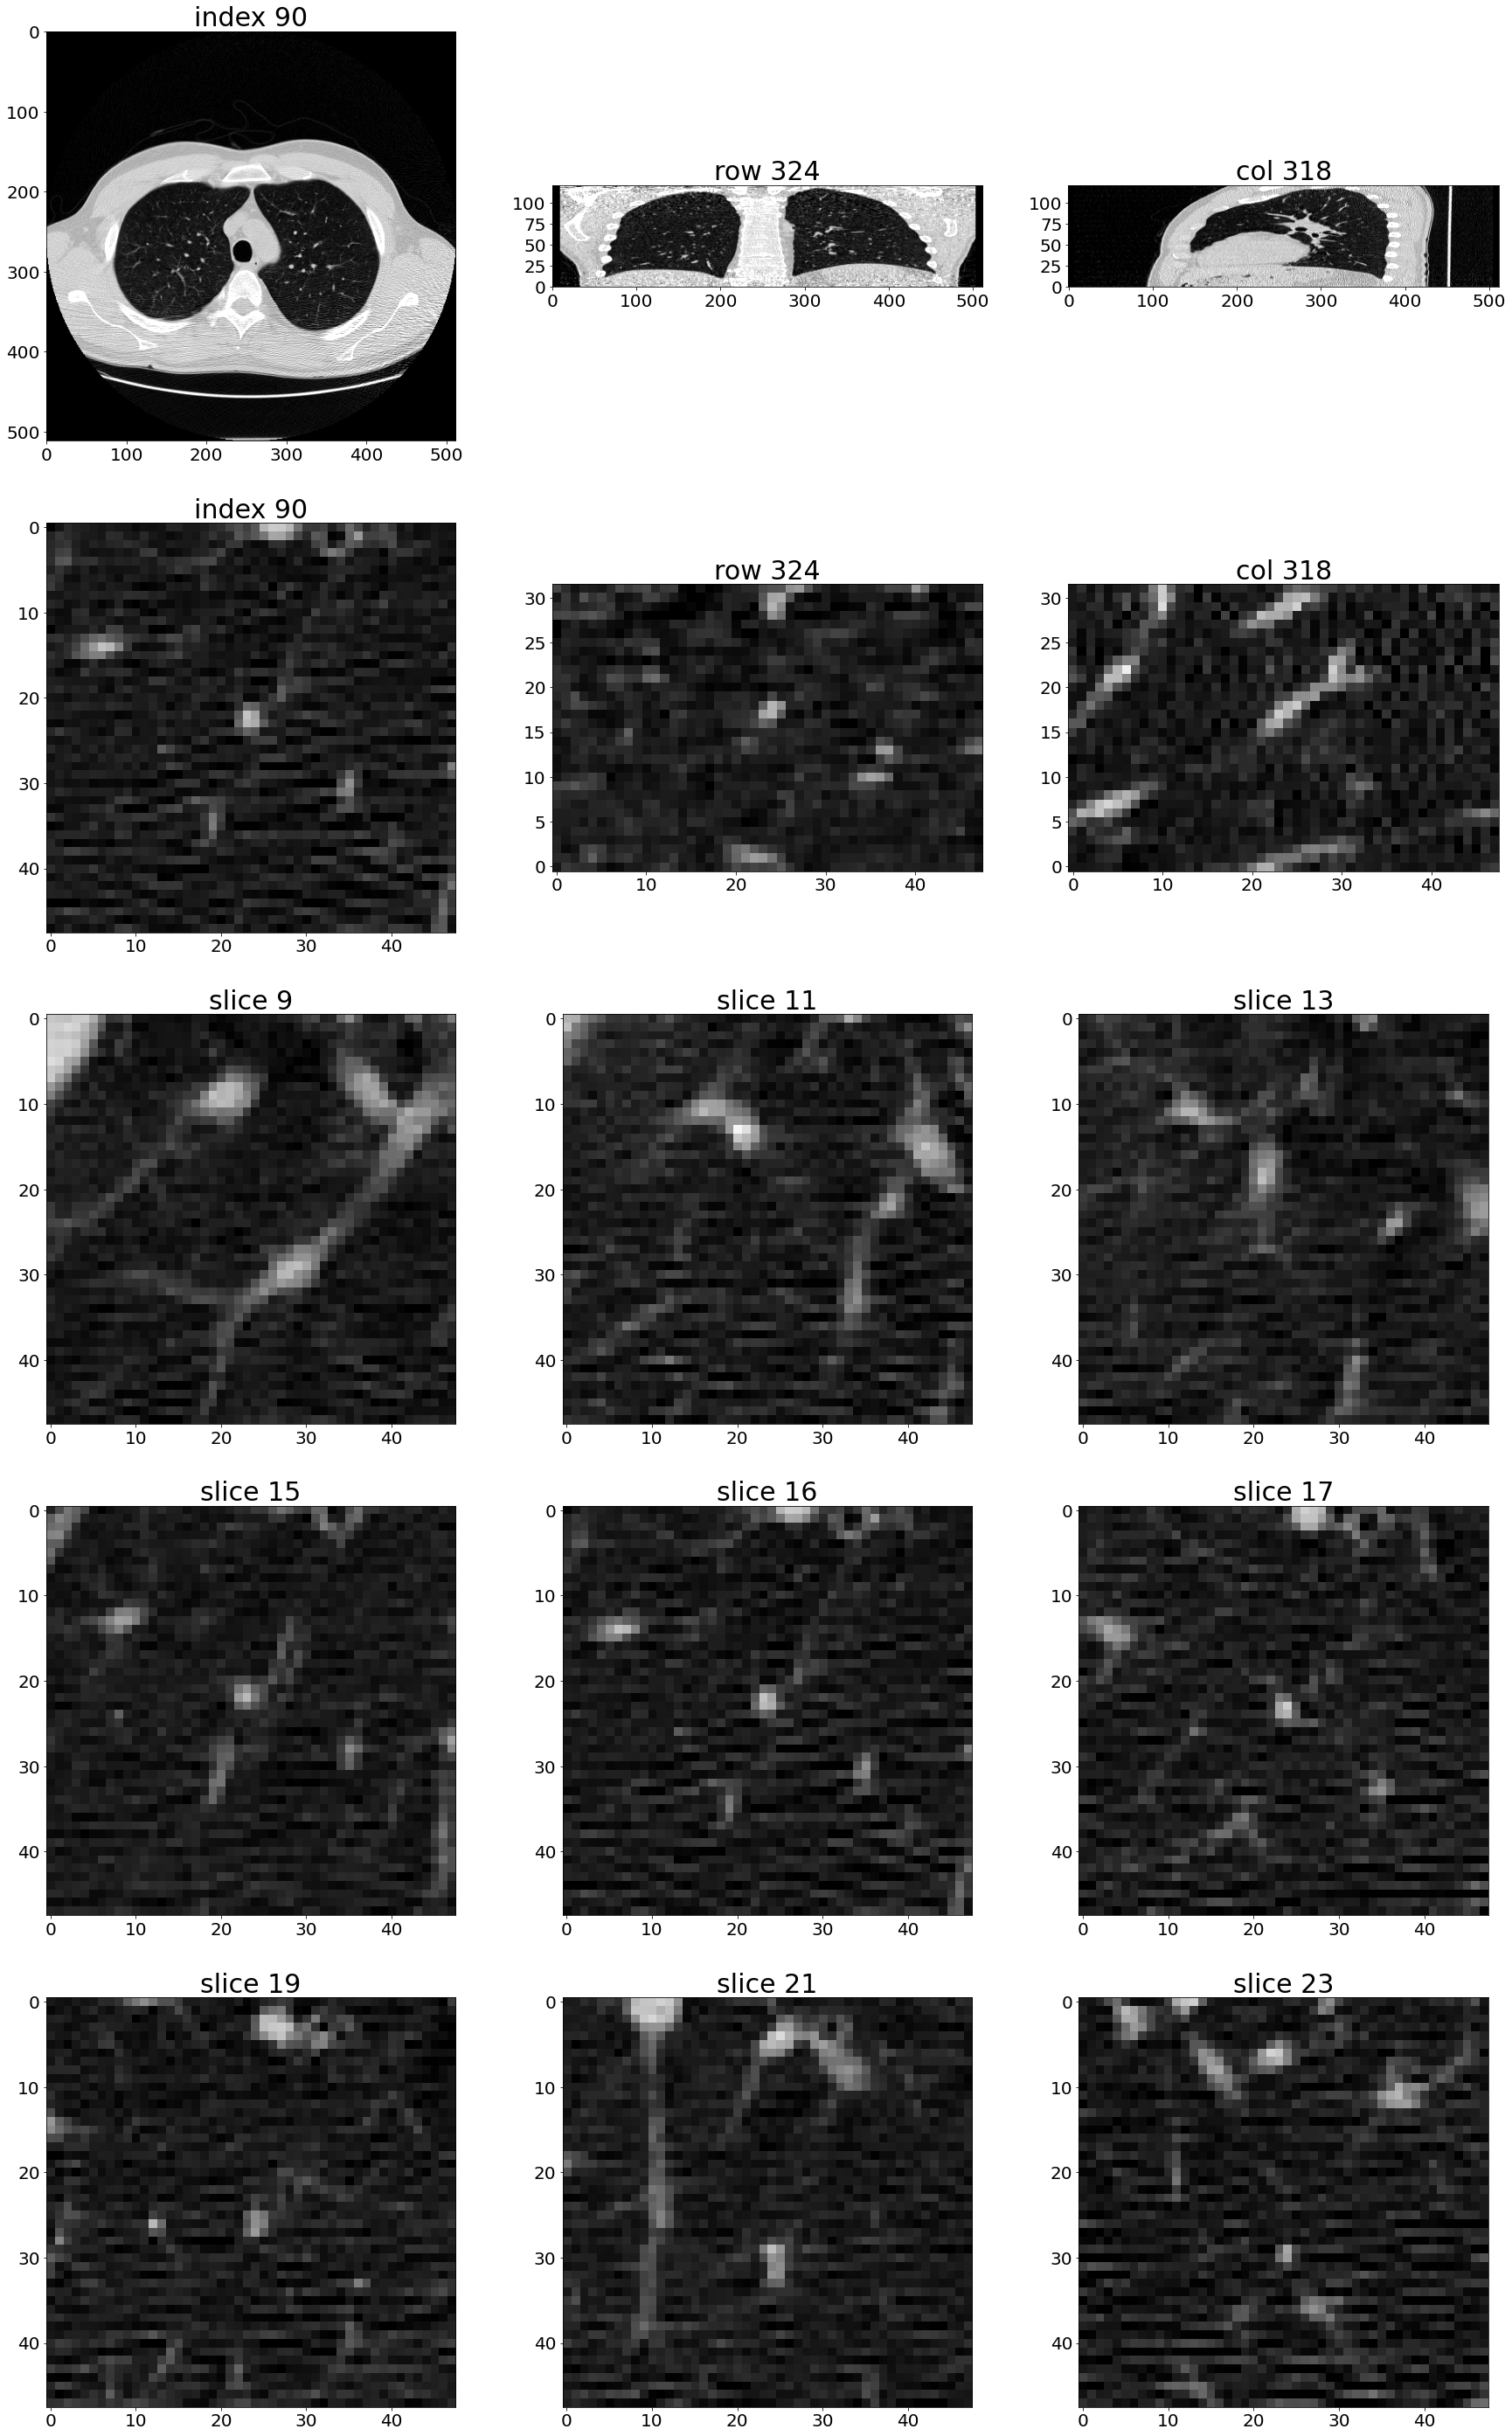

In [400]:
showCandidate(series_uid)

## 演習問題

In [295]:
@functools.lru_cache(1)

def getCandidateInfoList(requireOnDisk_bool=True):
    # We construct a set with all series_uids that are present on disk.
    # This will let us use the data, even if we haven't downloaded all of
    # the subsets yet.
    mhd_list = glob.glob('../deep-learning-with-pytorch-ja/data/part2/luna/subset*/*.mhd')
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}

    diameter_dict = {}
    with open('../deep-learning-with-pytorch-ja/data/part2/luna/annotations.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])

            diameter_dict.setdefault(series_uid, []).append(
                (annotationCenter_xyz, annotationDiameter_mm)
            )

    candidateInfo_list = []
    with open('../deep-learning-with-pytorch-ja/data/part2/luna/candidates.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]

            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue

            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

            candidateDiameter_mm = 0.0
            for annotation_tup in diameter_dict.get(series_uid, []):
                annotationCenter_xyz, annotationDiameter_mm = annotation_tup
                for i in range(3):
                    delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])
                    if delta_mm > annotationDiameter_mm / 4:
                        break
                else:
                    candidateDiameter_mm = annotationDiameter_mm
                    break

            candidateInfo_list.append(CandidateInfoTuple(
                isNodule_bool,
                candidateDiameter_mm,
                series_uid,
                candidateCenter_xyz,
            ))

    candidateInfo_list.sort(reverse=True)
    return candidateInfo_list

In [118]:
from util.logconf import logging
log = logging.getLogger(__name__)

In [119]:
import time
a = time.time()
dataset = LunaDataset()
b = time.time()

print(b-a)

2022-08-07 09:59:37,484 INFO     pid:24 __main__:023:__init__ <__main__.LunaDataset object at 0x7f16b78f8d60>: 2298 training samples


5.439709186553955
